In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from util.util_cnn import *

from util.util_gamma_rule import calc_vals_batch
from util.util_data_summary import plot_condition_number, plot_vals_lineplot, condition_number

In [2]:
%matplotlib inline

# Low dimensional toy model 
- plot development of gradients as we approach baseline

In [4]:
class ToyModel(nn.Module):
    def __init__(self, x_0, x_1, hidden_sizes=[2], seed=42):
        super().__init__()

        # Set the seed for random initialization
        if seed is not None:
            torch.manual_seed(seed)

        self.x_0 = torch.tensor(x_0, dtype=torch.float, requires_grad=True)
        self.x_1 = torch.tensor(x_1, dtype=torch.float, requires_grad=True)
        self.x_0.retain_grad()
        self.x_1.retain_grad()

        assert self.x_0.shape == self.x_1.shape and self.x_0.ndim == 1

        activation_sizes = [len(self.x_0)] + hidden_sizes + [1]

        # Define linear layers and initialize weights and biases randomly
        self.layers = nn.ModuleList()  # Use ModuleList to store layers
        for inp, out in zip(activation_sizes[:-1], activation_sizes[1:]):
            layer = nn.Linear(inp, out, bias=True)
            # Initialize weights and biases randomly
            nn.init.normal_(layer.weight, mean=0, std=0.4)
            nn.init.normal_(layer.bias, mean=.5, std=0.2)
            self.layers.append(layer)


    def forward(self, t):
        assert 0 <= t <= 1
        self.activations = []
        
        x = self.x_1 * (1-t) + self.x_0 * t
        x.retain_grad()
        self.activations.append(x)  # Store the input (x) activation

        for layer in self.layers:
            h = F.relu(layer(self.activations[-1]))
            h.retain_grad()
            self.activations.append(h)

        return self.activations[-1]

In [9]:
inputs = torch.tensor([[2,-3,5]])
outputs = torch.tensor([[0,0,0]])

/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_53576/3698739428.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_0 = torch.tensor(x_0, dtype=torch.float, requires_grad=True)
/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_53576/3698739428.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_1 = torch.tensor(x_1, dtype=torch.float, requires_grad=True)


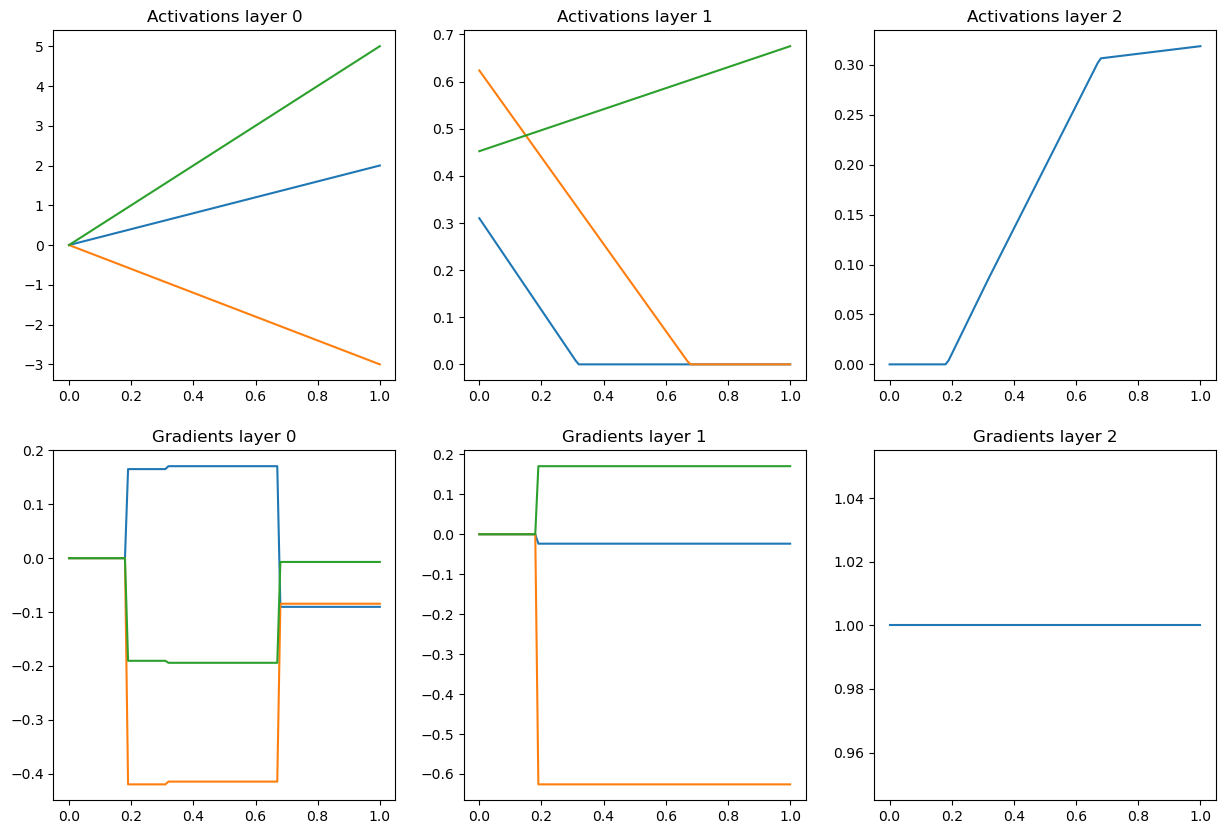

In [10]:
m = ToyModel(inputs[0], outputs[0], hidden_sizes=[3], seed=2)

Activations = []
Gradients = []
T = np.linspace(0, 1, 101)

for t in T:
    m.zero_grad()  # Clear previous gradients
    m.forward(torch.tensor(t, requires_grad=True, dtype=torch.float)).backward(retain_graph=True)
    # Collect values
    Activations.append({ ind: d.detach().numpy() for ind, d in enumerate(m.activations)})
    Gradients.append({ ind: d.grad.detach().numpy() for ind, d in enumerate(m.activations)})

# Plot activations
n_plots = len(Activations[0])
fig, axs = plt.subplots(2, n_plots, figsize=(5*n_plots, 10))
for name, df, ax_row in zip(['Activations', 'Gradients'], [pd.DataFrame(Activations), pd.DataFrame(Gradients)], axs):
    for ax, col in zip(ax_row, df.columns):
        arr = np.array(df[col].to_list())
        ax.plot(T, arr)
        ax.set_title(f"{name} layer {col}")

plt.show()

# Captum on MNIST model

In [11]:
model_dict = load_mnist_v4_models()
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']
data, target = first_mnist_batch(batch_size=10)

In [11]:
# import gauss_legendre_builders from captum:
from captum.attr._utils.approximation_methods import gauss_legendre_builders
from captum.attr._utils.common import _format_input_baseline
from captum.attr import IntegratedGradients

In [51]:
step_sizes, alphas = gauss_legendre_builders()

In [ ]:
from captum._utils.common import (
    _expand_additional_forward_args,
    _expand_target,
    _format_additional_forward_args,
    _format_output,
    _is_tuple
)
from captum.attr._utils.common import (
    _format_input_baseline,
    _reshape_and_sum,
    _validate_input,
)
from captum.attr._utils.approximation_methods import approximation_parameters

In [38]:


n = 1000
selected = [0,1,5,10,50,-51,-11,-6,-2,-1]
i_image = 2

ig_data = data[i_image:i_image+1].repeat(n,1,1,1)
ig_target = target[i_image:i_image+1].repeat(n)
ig_baseline = ig_data.detach().clone() * torch.linspace(0, 1, n).flip(0).reshape(n,1,1,1)

ig_data = ig_data[selected]
ig_target = ig_target[selected]
ig_baseline = ig_baseline[selected]

# applying integrated gradients on the SoftmaxModel and input data point
ig = IntegratedGradients(model_d3)
attributions, approximation_error = ig.attribute(ig_data, baselines=ig_baseline, target=ig_target,
                                    return_convergence_delta=True)

attributions = attributions.clone().detach().numpy()[:, 0]

# attributions, \
approximation_error

tensor([ 0.0000e+00, -1.1061e-06,  2.6093e-06, -8.5099e-06,  2.4429e-05,
        -1.0793e-02, -8.7737e-02,  1.3324e-01, -1.0204e-01,  1.5498e-02],
       dtype=torch.float64)

# My IG implementation

In [22]:
model_dict = load_mnist_v4_models()
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']
data, target = first_mnist_batch(batch_size=100)

In [3]:
def split_model(model, before_layer):
    layers = list(model.seq)
    return nn.Sequential(*layers[:before_layer]), nn.Sequential(*layers[before_layer:])

model_1, model_2 = split_model(model_d3, 2)
model_1, model_2

(Sequential(
   (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU()
   (2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
   (3): ReLU()
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
   (6): ReLU()
   (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU()
   (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (10): ReLU()
   (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (12): Flatten(start_dim=1, end_dim=-1)
   (13): Linear(in_features=256, out_features=10, bias=True)
 ))

In [5]:
torch.set_printoptions(precision=3, sci_mode=False)
model_d3(data[:1])

tensor([[    -4.090,     -1.650,      6.821,      3.524,     -1.524,     -7.528,
             -6.057,     -0.006,     12.957,      0.832]],
       grad_fn=<AddmmBackward0>)

In [6]:
a = torch.ones(4, requires_grad=True)
b = torch.arange(4, dtype=torch.float) - 1
c = a * b
c.backward(torch.ones_like(c))

c, a.grad

(tensor([-1.,  0.,  1.,  2.], grad_fn=<MulBackward0>),
 tensor([-1.,  0.,  1.,  2.]))

In [24]:
class IntermediateIntegratedGradients():
    """
    Supports two new features:
    - Capture and integrate the gradients at intermediate layers.
    - Compute Path integrals of different lengths at the same time, starting from input, extending towards baseline. For this we use a shared Rieman integral approximation.
    """
    def __init__(self, submodels) -> None:
        """
        Expects a list of submodels, which contain subsets of the layers of the model.
        Before every submodel, the inputs will be stored, and gradients will be captured and integrated.
        """
        self.submodels = submodels

    def attribute(self, inp, baseline_0=None, target=None, n_steps=50, baselines_at_steps=None, multiply_by_inputs=True, like_lrp=False):
        """
        input: tensor of shape (batch_size, *input_size)
        baseline: tensor of shape (batch_size, *input_size)
        target: tensor of shape (batch_size, *output_size)
        n_steps: number of steps to integrate over
        baselines_at_steps: list of integers, indicating the steps at which to integrate the gradients.
        """
        if baseline_0 is None:
            baseline_0 = torch.zeros(inp.shape)
        else:
            assert isinstance(baseline_0, torch.Tensor), "Baseline must be a tensor."
            assert baseline_0.shape == inp.shape, "Baseline must have the same shape as input."
        if baselines_at_steps is None:
            baselines_at_steps = 1 + np.arange(n_steps)
        elif isinstance(baselines_at_steps, int):
            baselines_at_steps = np.array([baselines_at_steps])
        elif isinstance(baselines_at_steps, list):
            baselines_at_steps = np.array(baselines_at_steps)
        else:
            assert isinstance(baselines_at_steps, np.ndarray), "baselines_at_steps must be None, int, list or np.ndarray"

        # Store inputs
        weights = torch.arange(n_steps+1) / n_steps # the linear combination from the first weight (0) is the baseline. We never use it's gradient, but need it when multiplying with (input - baseline).
        while weights.ndim <= inp.ndim:
            weights = weights[:,None]
        curr_submodel_path_inputs = baseline_0[None] + weights * (inp[None] - baseline_0[None])

        submodels_path_inputs = []
        # Compute forward pass, store intermediate results
        for i, submodel in enumerate(self.submodels):
            submodel.zero_grad()
            curr_submodel_path_inputs.requires_grad_(True)
            curr_submodel_path_inputs.retain_grad()
            submodels_path_inputs.append(curr_submodel_path_inputs)
            curr_submodel_path_inputs = submodel(curr_submodel_path_inputs)

        outputs_on_path = curr_submodel_path_inputs
        assert outputs_on_path.ndim == 2, "Only supports 1D outputs for now." #  (batched to 2D)

        if target is None:
            target = outputs_on_path[-1].argmax()
        else:
            assert type(target) is int and target < outputs_on_path.shape[1], f"Target must be an integer smaller than the number of outputs. {target} !< {outputs_on_path.shape}"

        target_logit = outputs_on_path[-1, target]

        outputs_target_class = outputs_on_path[:,target]
        
        if like_lrp:
            if target_logit > 0:
                # the following is a debatable design choice. We normalise the inital gradient of the target classto get a standard form of the linear operator similar to how we did it in LRP.
                # the resulting operator can take the entire output layer logit vector (not only ones, but real activations), and transform it to the heatmap that integrated gradients would give for every score.
                initial_gradients = torch.ones_like(outputs_target_class) / target_logit
            else:
                # this is silly commputation. here we should just omit the backward pass.
                initial_gradients = torch.zeros_like(outputs_target_class) 
        else:
            initial_gradients = torch.ones_like(outputs_target_class)

        outputs_target_class.backward(initial_gradients)

        submodel_path_gradients = [inp.grad.clone().detach() for inp in submodels_path_inputs]
        integration_matrix = torch.zeros((len(baselines_at_steps), n_steps+1))
        # to achieve different integral lengths / "#steps in integral" we take the (equally weighted) mean over different steps in the 
        for i, at in enumerate(baselines_at_steps):
            integration_matrix[i, (-at):] = 1/at

        submodel_integrated_gradients = [torch.einsum('ij,j...->i...', integration_matrix, grad) for grad in submodel_path_gradients]

        if multiply_by_inputs:
            submodel_integrated_gradients = [grad * (inp[-1:] - inp[-1-baselines_at_steps]) # (avg. grad on path) * (input - baseline)
                                             for inp, grad 
                                             in zip(submodels_path_inputs, submodel_integrated_gradients)]
            

        submodel_integrated_gradients = [g.detach().numpy().copy() for g in submodel_integrated_gradients]
        return submodel_integrated_gradients
# grads = iig.attribute(data[0], baseline_0=None, target=None, n_steps=10)
# [g.shape for g in grads] # (layers, baselines, *(layer_size))

## Further Dev

In [108]:
inp = torch.tensor(1., requires_grad=True)
W = torch.arange(2*3*4).reshape((2,3,4)) * 1.
# W.requires_grad_().retain_grad()
res = inp * W

def zero_grad():
    if inp.grad is not None: inp.grad.zero_()
    # if   W.grad is not None:   W.grad.zero_()
    # if res.grad is not None: res.grad.zero_()

for i in range(np.prod(res.shape)):
    zero_grad()
    res.view(-1)[i].backward()
    print(inp.grad, W.grad)

    if i>4: break

    # google: how to clear graph to backward a second time ?

tensor(0.) None


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [99]:
np.prod(res.shape)

res.view(-1)[7]

tensor(7., grad_fn=<SelectBackward0>)

In [90]:
a = torch.tensor(3., requires_grad=True)
b = 3 * a
b.retain_grad()
c = torch.tensor([1,1]) * b
c.retain_grad()
d = 3 * c

In [67]:
a.grad

tensor(3.)

In [68]:
c[1].backward(retain_graph=True)
print(a.grad)



tensor(9.)


In [54]:
a.grad

tensor(9.)

## Run it

In [25]:
iig = IntermediateIntegratedGradients([model_1, model_2])
n_steps=100
n_points = 100
n_classes = 10

grads_list = [[iig.attribute(inp, baseline_0=None, target=t, n_steps=n_steps, like_lrp=True)
                for t in range(n_classes)]
                for inp in data[:n_points]]                          # (points, classes, layers, baselines, *(layer_size))
# transpose
grads = []                                                           # (layers, points, classes, baselines, *(layer_size))
for i in range(len(grads_list[0][0])):
    for_layer = [[g2[i] for g2 in g1] for g1 in grads_list]
    for_layer = np.array(for_layer).reshape((n_points, n_classes, n_steps, -1)).transpose((0,2,1,3))
    grads.append(for_layer)

grads_iig = grads.copy()

print(len(grads), grads[0].shape)
print(type(grads), type(grads[0]), type(grads[0][0]), type(grads[0][0][0]), type(grads[0][0][0][0]))

2 (100, 100, 10, 784)
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [40]:
def calc_iig(
    iig, 
    n_steps = 1,
    baseline_at_steps = None,
    n_points = 100,
    n_classes = 10,
    like_lrp=True, multiply_by_inputs=True):

    grads_list = [[iig.attribute(inp, baseline_0=None, target=t, n_steps=n_steps, like_lrp=like_lrp, multiply_by_inputs=multiply_by_inputs)
                    for t in range(n_classes)]
                    for inp in data[:n_points]]                          # (points, classes, layers, baselines, *(layer_size))
    # transpose
    grads = []                                                           # (layers, points, classes, baselines, *(layer_size))
    for i in range(len(grads_list[0][0])):
        for_layer = [[g2[i] for g2 in g1] for g1 in grads_list]
        for_layer = np.array(for_layer).reshape((n_points, n_classes, n_steps, -1)).transpose((0,2,1,3))
        grads.append(for_layer)

    return grads

iig = IntermediateIntegratedGradients([model_1, model_2])
grads = calc_iig(iig, multiply_by_inputs=False)
i_grads = calc_iig(iig, multiply_by_inputs=True, n_steps=100, baseline_at_steps=[100])

print(len(grads), grads[0].shape)
print(type(grads), type(grads[0]), type(grads[0][0]), type(grads[0][0][0]), type(grads[0][0][0][0]))

2 (100, 1, 10, 784)
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Svals

In [41]:
svals_grads = calc_vals_batch(grads, num_vals='auto', tqdm_for='point', return_vecs=False)
svals_i_grads = calc_vals_batch(i_grads, num_vals='auto', tqdm_for='point', return_vecs=False)

print(svals_grads.shape, svals_i_grads.shape)

100it [00:00, 1605.48it/s]
100it [00:00, 556.05it/s]
100it [00:03, 30.03it/s]
100it [00:21,  4.61it/s]

(2, 100, 1, 7) (2, 100, 100, 7)


(2, 100)
(2.4525176110930103, 474.591161008224)
(2.3855244247560115, 456.5341774260212)


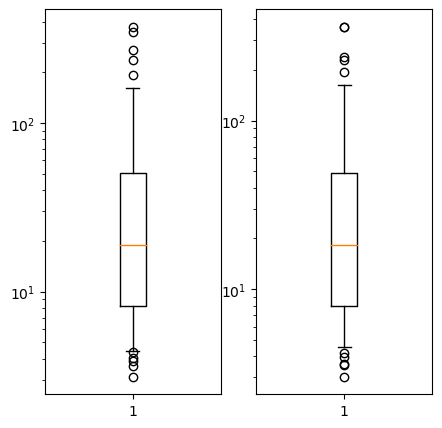

In [46]:
d = condition_number(svals_grads, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
for ax, d in zip(axs, d):    
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    print(ax.get_ylim())

(2, 100)


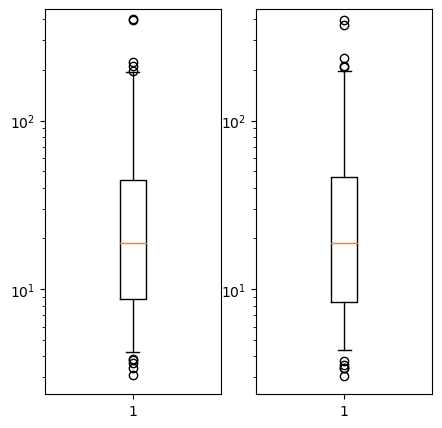

In [47]:
d = condition_number(svals_i_grads, percentile=.95)[:, :, -1]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
for ax, d in zip(axs, d):    
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim((2.3855244247560115, 456.5341774260212))

{'whiskers': [<matplotlib.lines.Line2D at 0x150a09d50>,
 'caps': [<matplotlib.lines.Line2D at 0x150a0a2f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x150a09a80>],
 'medians': [<matplotlib.lines.Line2D at 0x15097ab90>],
 'fliers': [<matplotlib.lines.Line2D at 0x15097ae60>],
 'means': []}

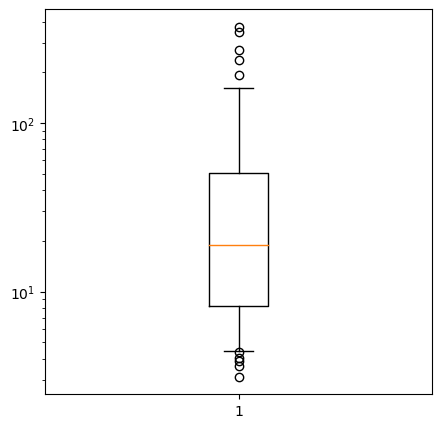

In [ ]:
d = condition_number(svals_l1, percentile=.95)[0, :, 0]
# boxplot vertical, log scaled y axis:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_yscale('log')
ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])

In [12]:
# from output layer to layer 0
svals, lvecs, rvecs = calc_vals_batch(grads[:1], num_vals='auto', tqdm_for='point', return_vecs=True)

100it [00:00, 1399.60it/s]


In [33]:
# from output layer to layer 1
svals_l1, lvecs_l1, rvecs_l1 = calc_vals_batch(grads[1:], num_vals='auto', tqdm_for='point', return_vecs=True)

100it [00:00, 476.13it/s]


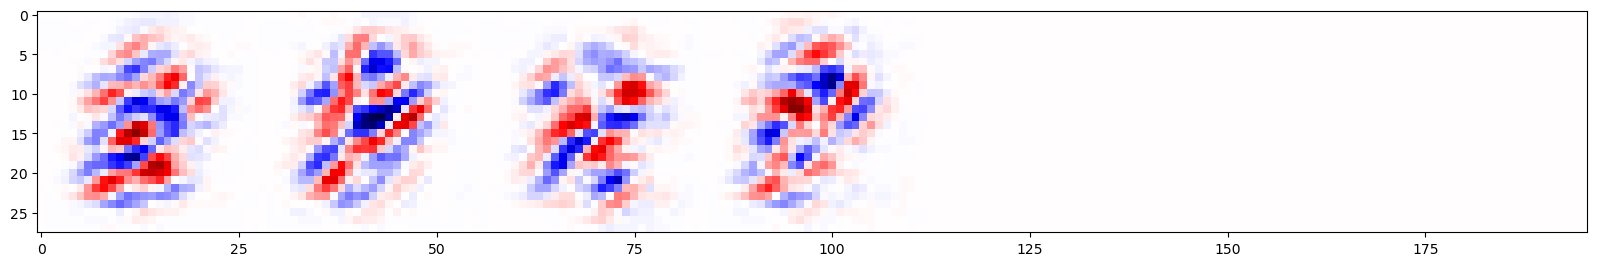

In [16]:
my_rvecs = rvecs_l1.copy()

# which steps
my_steps = (0, 10, 50, -11, -1)
my_steps = (0,)

n_weights, n_points, n_steps, n_vals, shape_flattened = my_rvecs.shape
n_my_steps = len(my_steps)

data = my_rvecs[0,0,my_steps].reshape(n_my_steps, n_vals, -1, 28, 28).mean(axis=2).transpose((0, 2, 1, 3)).reshape(n_my_steps*28, n_vals*28)
maxi = np.max(np.abs(data))
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(data, vmin=-maxi, vmax=maxi, cmap='seismic')

## Svals with parameters

(<Figure size 2000x1000 with 1 Axes>,
 array([<AxesSubplot:xlabel='$\\gamma$', ylabel='Singular values'>],
       dtype=object))

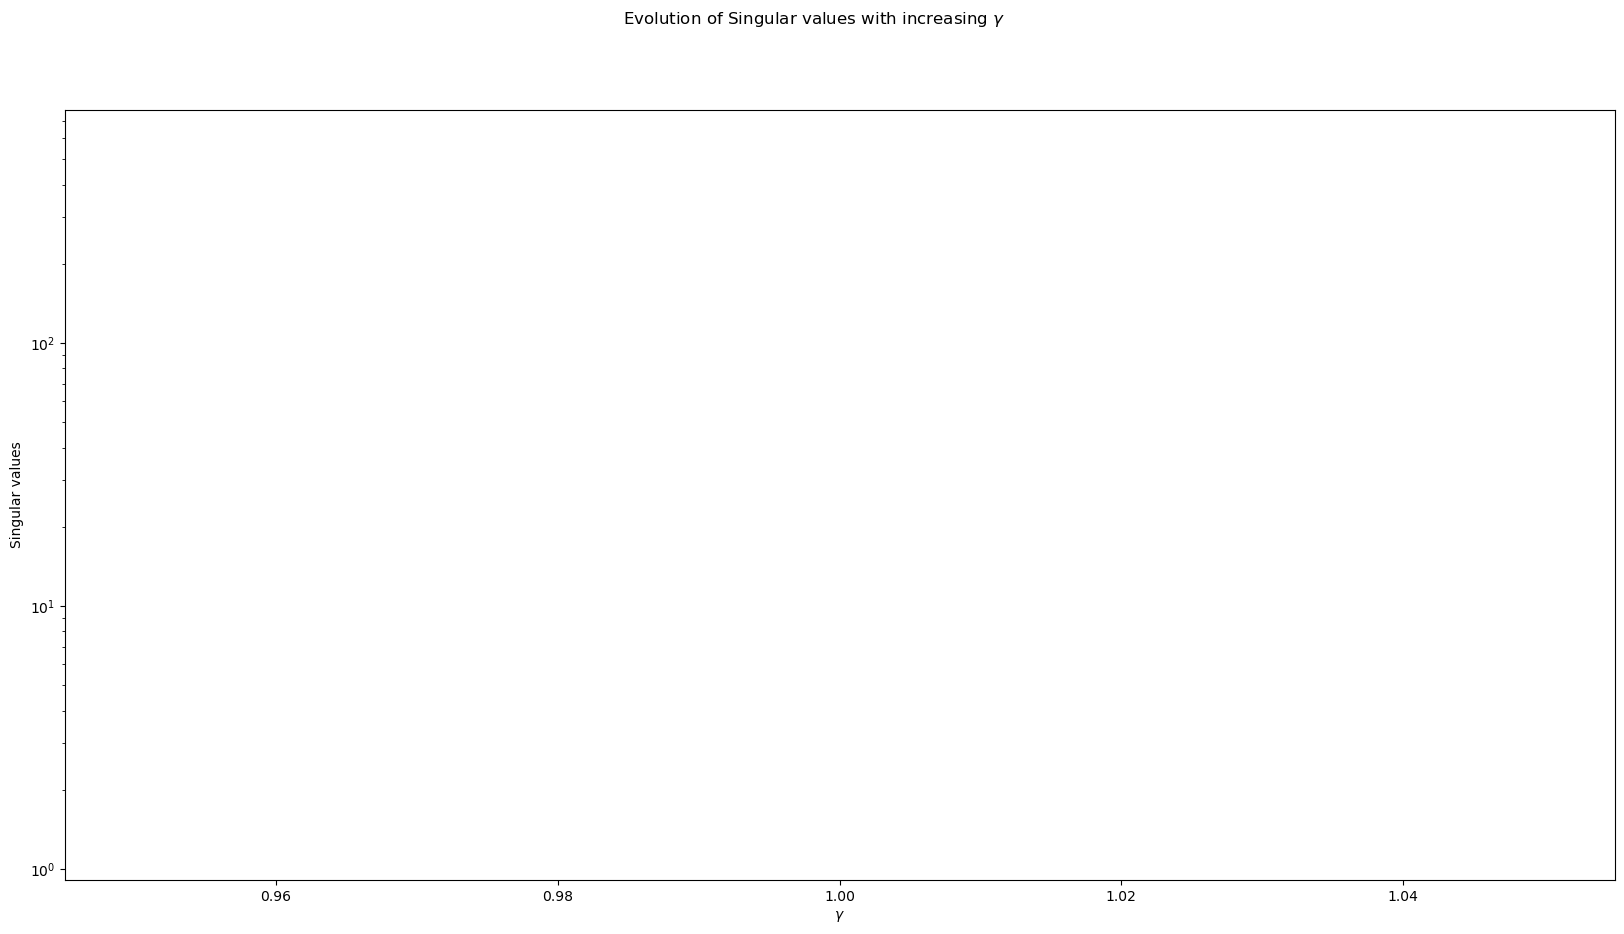

In [17]:
vals = svals[:, :, :, :1] # / svals[:, :, :, :]
# vals -= vals[:, :, :1]

plot_vals_lineplot(vals, 1+np.arange(svals.shape[2]), ylim=(1,700), yscale='log', num_vals_total=200, colormap='seismic', one_plot_per='weight')

lines


(<Figure size 500x600 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\gamma$', ylabel='$\\kappa_q$'>])

<Figure size 640x480 with 0 Axes>

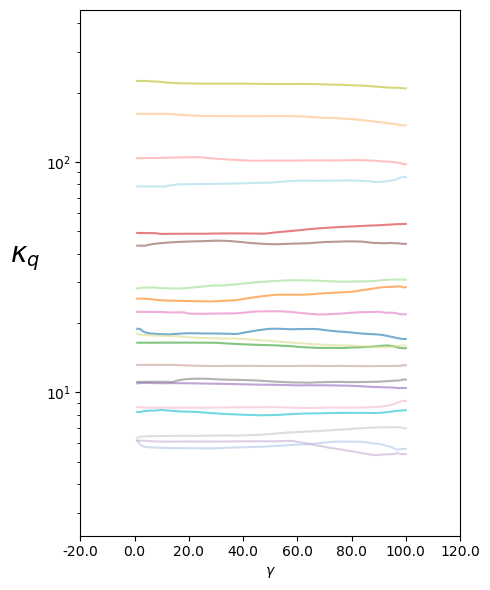

In [51]:
plot_condition_number(svals_i_grads[1:, :20], gammas=1+np.arange(100), xscale='linear', xlim=(0,101), mode='lines', 
                      ylim=(2.3855244247560115, 456.5341774260212), yscale='log'
                    #   ylim=(-10,10), yscale='linear'
                      )

lines


(<Figure size 1000x600 with 2 Axes>,
 [<AxesSubplot:xlabel='$\\gamma$', ylabel='$\\kappa_q$'>,
  <AxesSubplot:xlabel='$\\gamma$'>])

<Figure size 640x480 with 0 Axes>

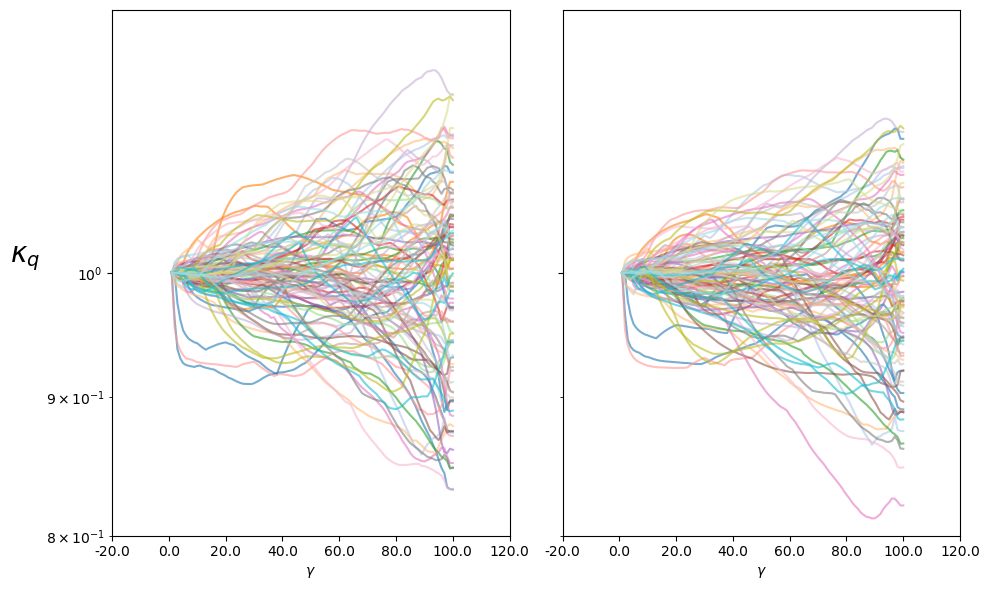

In [ ]:
plot_condition_number(svals, gammas=1+np.arange(100), xscale='linear', xlim=(0,101), mode='lines', 
                      ylim=(.8, 1.25), yscale='log'
                    #   ylim=(-10,10), yscale='linear'
                      )

/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_1042/3557728950.py:4: RuntimeWarning: divide by zero encountered in divide
  vals = svals[:, :, :, :1] / svals[:, :, :, :]


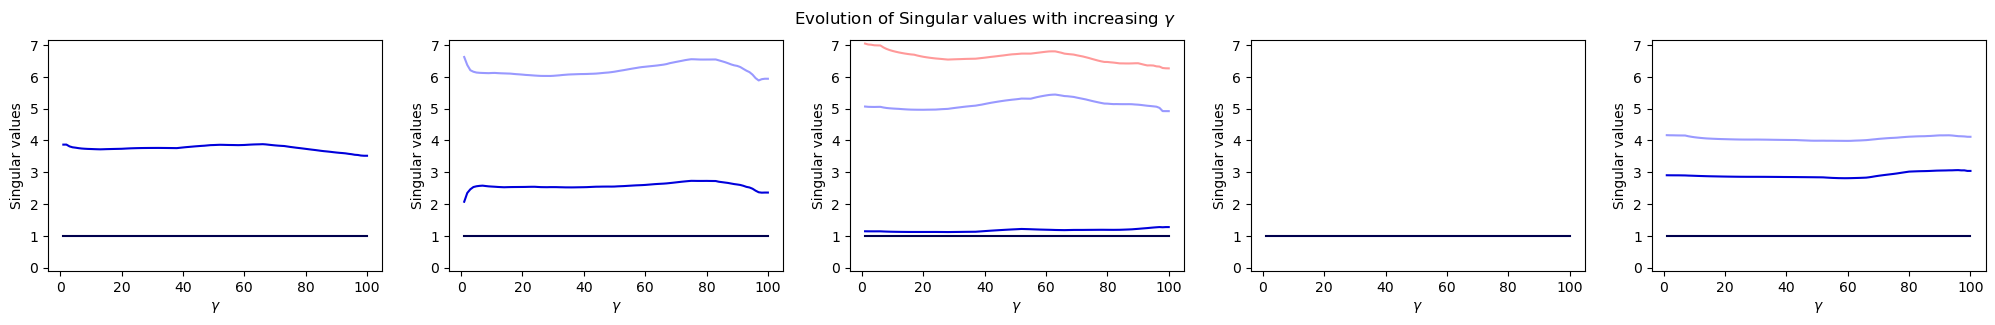

In [139]:
from util.util_gamma_rule import plot_vals_lineplot

vals = svals
vals = svals[:, :, :, :1] / svals[:, :, :, :]

plot_vals_lineplot(vals, 1+np.arange(vals.shape[2]), ylim=(0,7), yscale='linear', num_vals_total=200, colormap='seismic', one_plot_per='point')

In [149]:
np.array(grads_per_layer, dtype=object).shape

/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_63063/1363113278.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(grads_per_layer, dtype=object).shape


(2,)

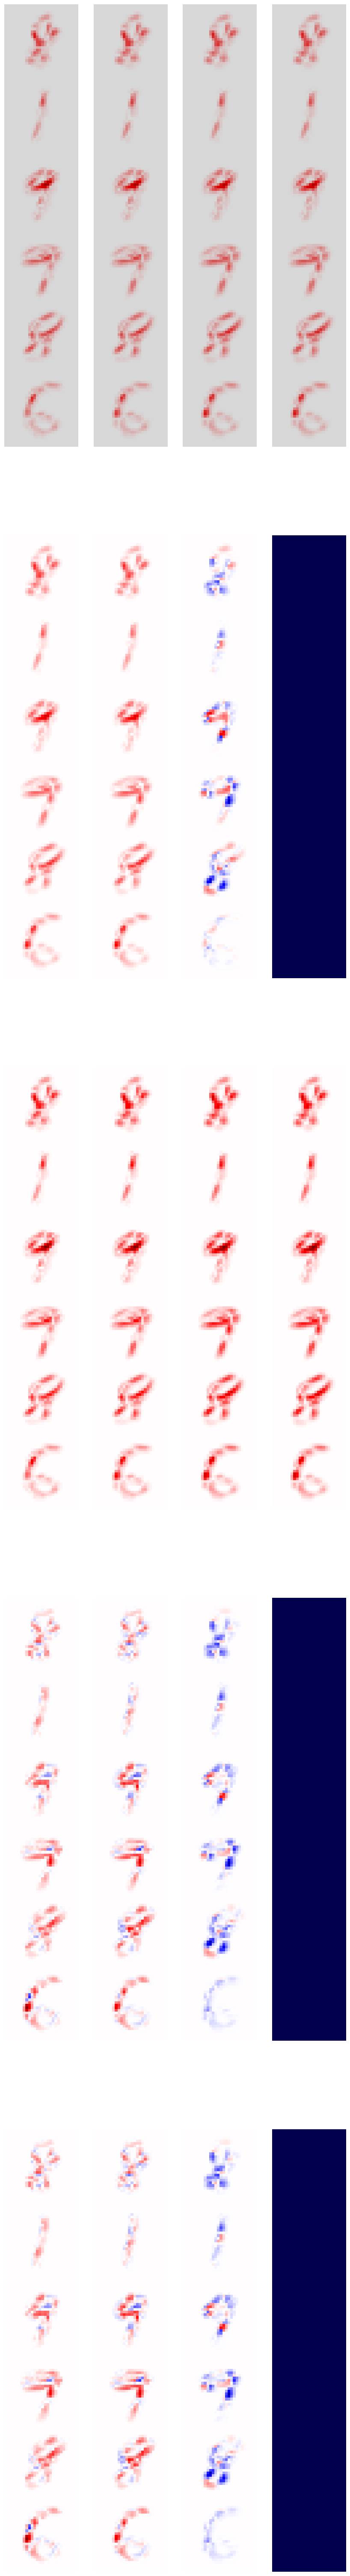

In [50]:
R = attributions[-1]
b = 10*((np.abs(R)**3.0).mean()**(1.0/3))

n_rows=5
scale=2

fig, axs = plt.subplots(n_rows, len(attributions), figsize=(len(attributions)*scale, n_rows*len(attributions[0])*scale))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)

width = R.shape[-1]

for ax, R in zip(axs[0], attributions):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    R = R.reshape(-1,width)
    ax.imshow(R,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    ax.axis('off')

for ax, R in zip(axs[1], attributions):
    R = attributions[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

attributions_abs_normalized = []
attributions_normalized = []
for att in attributions:
    absi = np.abs(att)
    maxi = absi.max()
    attributions_abs_normalized.append(absi / maxi)
    attributions_normalized.append(att / maxi)

for ax, R in zip(axs[2], attributions_abs_normalized):
    b = 1
    ax.imshow(R.reshape(-1,width), plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

for ax, R in zip(axs[3], attributions_abs_normalized):
    R = attributions_abs_normalized[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

for ax, R in zip(axs[4], attributions_normalized):
    R = attributions_normalized[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

plt.show()